In [1]:
import numpy as np

og_image = np.ones((96, 96), dtype=float)

og_image.shape

(96, 96)

In [2]:
import matplotlib.pyplot as plt

def display_image(image, title='Image'):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray', origin='lower')  # 'origin' ensures correct orientation
    plt.colorbar(label='Pixel Value')
    plt.title(title)
    plt.xlabel('X Pixels')
    plt.ylabel('Y Pixels')
    plt.show()

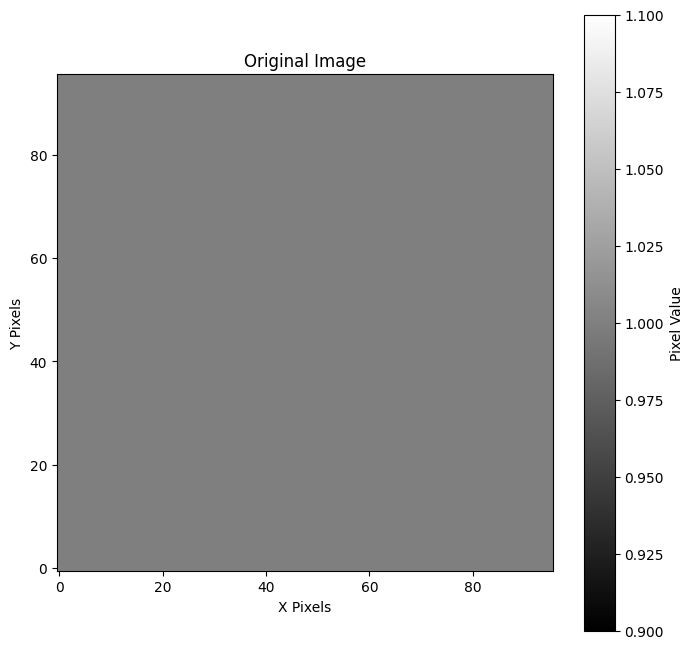

In [3]:
display_image(og_image, title='Original Image')

In [4]:
def add_psf(initial_img):
    # Assume you already have a 100x100 numpy array
    grid = initial_img  # Replace with your existing array

    # Grid size
    grid_size = grid.shape[0]

    # Generate a 2D grid
    x = np.arange(0, grid_size, 1)
    y = np.arange(0, grid_size, 1)
    X, Y = np.meshgrid(x, y)

    # Randomly choose a center for the Gaussian
    mu_x = np.random.randint(0, grid_size)
    mu_y = np.random.randint(0, grid_size)

    # Define Gaussian parameters
    sigma = 3  # Standard deviation (spread of the PSF)
    amplitude = 4  # Peak intensity

    # Generate Gaussian function
    gaussian = amplitude * np.exp(-((X - mu_x)**2 + (Y - mu_y)**2) / (2 * sigma**2))

    # Add the Gaussian spike to the existing grid
    grid += gaussian

    return grid

In [5]:
input_images = []
target_images = []

for i in range(2000):
    # Add a random PSF to the image
    noisy_image = add_psf(og_image.copy())

    target_image = og_image.copy()
    
    # Append the original and noisy images to the lists
    input_images.append(noisy_image)
    target_images.append(target_image)

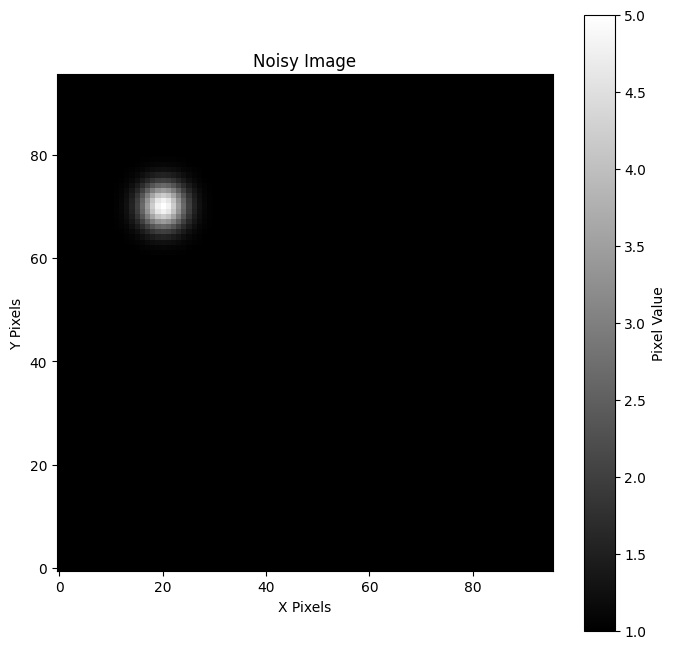

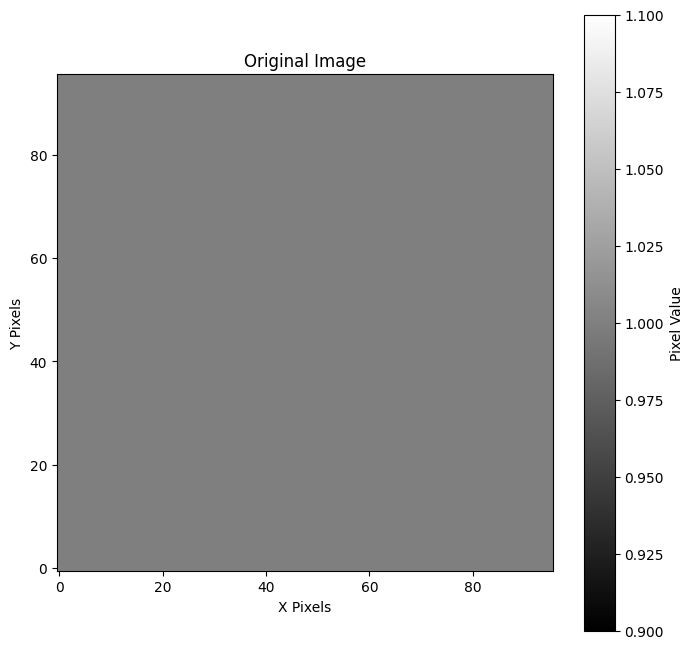

In [6]:
display_image(input_images[0], title='Noisy Image')
display_image(target_images[0], title='Original Image')

In [7]:
from monai.networks.nets import AttentionUnet

# Define the model
model = AttentionUnet(
    spatial_dims=2,  # Set to 3 for 3D inputs
    in_channels=1,   # Number of input channels
    out_channels=1,  # Number of output channels
    channels=(96, 128, 256, 512),  # Channels in each layer
    strides=(2, 2, 2),  # Strides for downsampling
    kernel_size=3,  # Convolution kernel size
    up_kernel_size=3,  # Upsampling kernel size
    dropout=0.1,  # Dropout rate
)

In [8]:
import torch

class AGNDataSet:
    def __init__(self, inputs, targets):
        self.inputs, self.targets = self._convert_to_tensor(inputs, targets)

    def _convert_to_tensor(self, inputs, targets):
        # Convert the inputs and targets to PyTorch tensors
        inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(1)
        targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(1)
        return inputs, targets


    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        # Return the input and target image
        return self.inputs[index], self.targets[index]

In [9]:
class Trainer:
    def __init__(self, model, dataset, device='cuda'):
        self.model = model.to(device)
        self.dataset = dataset
        self.device = device

    def train(self, epochs=10, batch_size=4):
        # Define the loss function
        loss_function = torch.nn.L1Loss()

        # Define the optimizer
        optimizer = torch.optim.Adam(model.parameters(), 1e-3)

        # Create a PyTorch DataLoader
        data_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, shuffle=True)

        # Iterate over epochs
        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}")

            # Iterate over the data loader
            for inputs, targets in data_loader:
                # Move the data to the device
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)

                # Zero the gradients
                optimizer.zero_grad()

                # Generate predictions
                predictions = self.model(inputs)

                # Calculate the loss
                loss = loss_function(predictions, targets)

                # Perform backpropagation
                loss.backward()

                # Update the weights
                optimizer.step()

            print(f"Loss: {loss.item()}")

In [10]:
torch.tensor(input_images).unsqueeze(1).shape

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)


torch.Size([2000, 1, 96, 96])

In [11]:
dataset = AGNDataSet(input_images, target_images)
trainer = Trainer(model, dataset)
trainer.train(epochs=25, batch_size=8)

Epoch 1
Loss: 0.0542183518409729
Epoch 2
Loss: 0.038916755467653275
Epoch 3
Loss: 0.030746830627322197
Epoch 4
Loss: 0.02513045072555542
Epoch 5
Loss: 0.020818587392568588
Epoch 6
Loss: 0.01750124804675579
Epoch 7
Loss: 0.014798615127801895
Epoch 8
Loss: 0.011826355941593647
Epoch 9
Loss: 0.009928988292813301
Epoch 10
Loss: 0.008135946467518806
Epoch 11
Loss: 0.006656388286501169
Epoch 12
Loss: 0.005780208855867386
Epoch 13
Loss: 0.004479011986404657
Epoch 14
Loss: 0.003702648915350437
Epoch 15
Loss: 0.0028847227804362774
Epoch 16
Loss: 0.002812175313010812
Epoch 17
Loss: 0.0020407862029969692
Epoch 18
Loss: 0.0018537696450948715
Epoch 19
Loss: 0.0015302699757739902
Epoch 20
Loss: 0.0012589790858328342
Epoch 21
Loss: 0.0015342335682362318
Epoch 22
Loss: 0.0005568191409111023
Epoch 23
Loss: 0.0005898945382796228
Epoch 24
Loss: 0.0002387221611570567
Epoch 25
Loss: 0.0004538217035587877


In [12]:
model = trainer.model

noisy_image = add_psf(og_image.copy())
noisy_image_tensor = torch.tensor(noisy_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to('cuda')

target_image = og_image.copy()
target_image_tensor = torch.tensor(target_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to('cuda')

noisy_image_tensor.shape

torch.Size([1, 1, 96, 96])

In [13]:
restored_image_tensor = model(noisy_image_tensor)

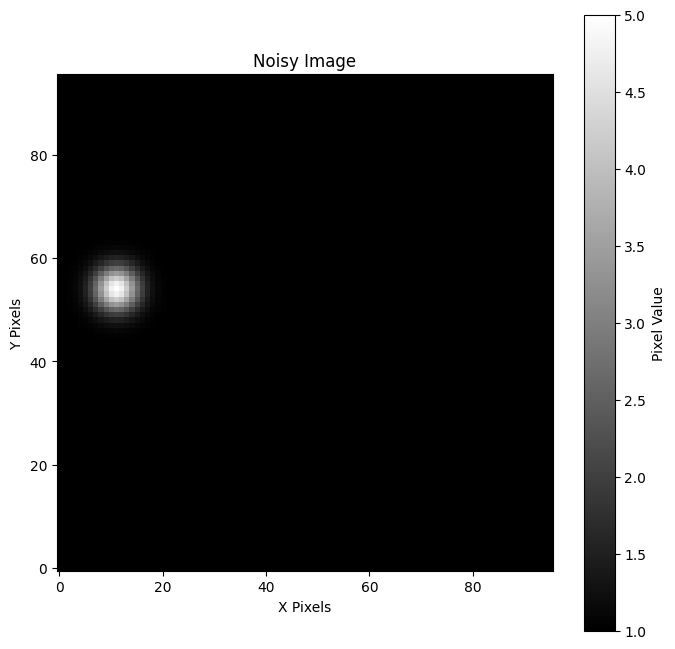

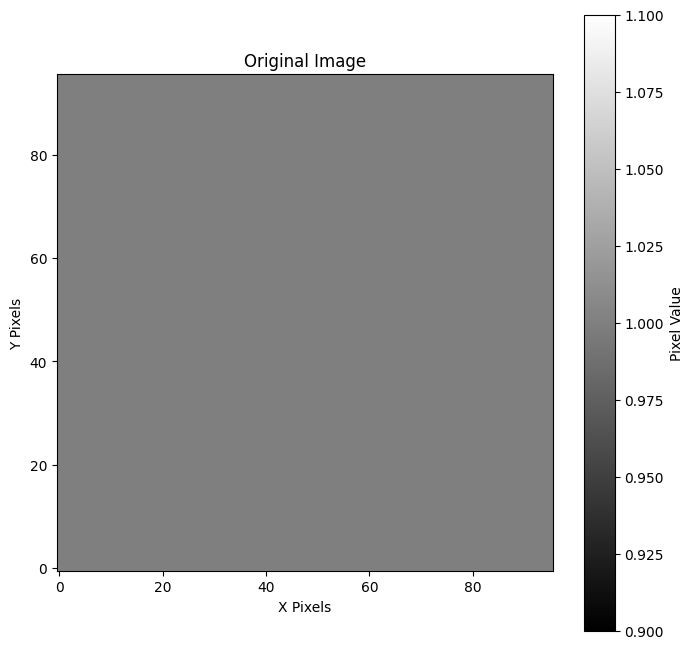

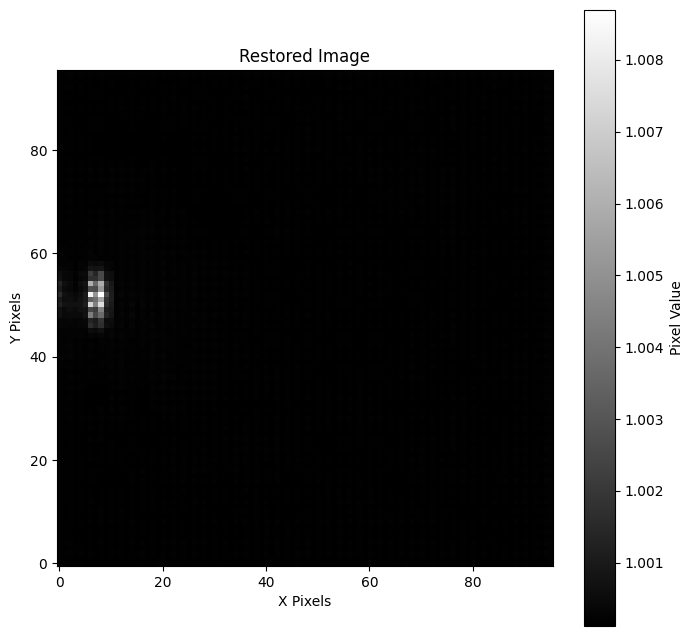

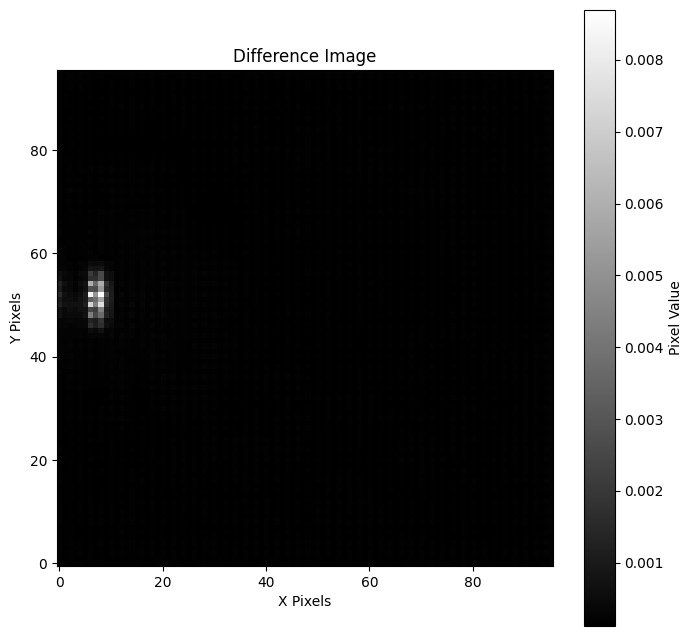

In [14]:
restored_image_tensor = restored_image_tensor.to('cpu')

display_image(noisy_image, title='Noisy Image')
display_image(target_image, title='Original Image')
display_image(restored_image_tensor.squeeze().detach().numpy(), title='Restored Image')
display_image(np.abs(target_image - restored_image_tensor.squeeze().detach().numpy()), title='Difference Image')